## U shape PHP dynamics

 Momentum equation:
 ## $\frac{\mathrm{d}^{2} X_{p}}{\mathrm{d} \tau^{2}}+32 \frac{\mathrm{d} X_{p}}{\mathrm{d} \tau}+\omega_{0}^{2} X_{p}=\wp\left(P_{1}-P_{2}\right)$
 
 
 We actrually solve this system of ODE:
 ## $\begin{equation}
     \textbf{U}=\left(\begin{array}{c}  X_{p}  \\ \frac{\mathrm{d} X_{p}}{\mathrm{d} \tau} \\ M_{1} \\ M_{2} \end{array}\right)
 \end{equation}$
 
 ## $P_{1} = (\frac{M_{1}}{1+X_{p}})^{\gamma}, P_{2} = (\frac{M_{2}}{1+X_{p}})^{\gamma}$
 
 ## $\theta_{1} = P_{1}^{\frac{\gamma-1}{\gamma}}, \theta_{2} = P_{2}^{\frac{\gamma-1}{\gamma}}$
 
 ## $\begin{equation} \frac{\mathrm{d} \textbf{U}}{\mathrm{d} \tau}= \left(\begin{array}{c}  \frac{\mathrm{d} X_{p}}{\mathrm{d} \tau} \\ -32 \frac{\mathrm{d} X_{p}}{\mathrm{d} \tau} - \omega_{0}^2 X_{p} +\zeta (P_{1} - P_{2}) \\ -H_{\mathrm{c}} X_{p}\left(\theta_{1}-\theta_{\mathrm{c}}\right)  \\ H_{\mathrm{e}}\left(1-X_{p}\right)\left(\theta_{\mathrm{e}}-\theta_{2}\right) \end{array} \right) ,  X_{p}> 0 \end{equation} $
 
  ## $\begin{equation} \frac{\mathrm{d} \textbf{U}}{\mathrm{d} \tau}= \left(\begin{array}{c}  \frac{\mathrm{d} X_{p}}{\mathrm{d} \tau} \\ -32 \frac{\mathrm{d} X_{p}}{\mathrm{d} \tau} - \omega_{0}^2 X_{p} +\zeta (P_{1} - P_{2}) \\ -H_{\mathrm{e}}\left(1+X_{p}\right)\left(\theta_{\mathrm{e}}-\theta_{1}\right)  \\ H_{\mathrm{c}} X_{p}\left(\theta_{2}-\theta_{\mathrm{c}}\right) \end{array} \right) ,  X_{p}< 0 \end{equation} $

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using DifferentialEquations

## Parameters of the PHP

In [11]:
    ω0 = sqrt(1.2e004);
    ζ = 1.2e005;


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;
    
    X0 = 0.5;

## Initialization of the PHP

In [12]:
    γ = 1.4;
    X = X0;
    P = [1.0,1.0];
    θ = [1.0,1.0];
    
    # only good for one liquid slug
    M = zeros(size(θ))
    M[1] = P[1].^(1/γ).*(1 + X);
    M[2] = P[2].^(1/γ).*(1 - X);

## Set up the ODE equations

In [13]:
    p = (γ,Hc,He,θc,θe,ω0,ζ);

function php!(du,u,p,t)
    
    γ,Hc,He,θc,θe,ω0,ζ  = p
    
    P[1] = (u[3]/(1+u[1]))^(γ) 
    P[2] = (u[4]/(1-u[1]))^(γ) 
    θ[1] = P[1]^((γ-1)/γ)
    θ[2] = P[2]^((γ-1)/γ)
    
    du[1] = u[2]
    du[2] = -32*u[2] - (ω0^2)*u[1] + ζ*(P[1]-P[2])
    u[1] > 0 ? du[3] = -Hc*u[1]*(θ[1] - θc) : du[3] = He*(1 + u[1])*(θe - θ[1]) 
    u[1] > 0 ? du[4] = He*(1-u[1])*(θe - θ[2]) : du[4] = Hc*u[1]*(θ[2] - θc)
    
    return du
end

php! (generic function with 1 method)

## Solve the ODE equations

In [14]:
u0 =  [0.5,0.0,M[1],M[2]]
tspan = (0.0, 0.05);
prob = ODEProblem(php!, u0, tspan, p)
sol = solve(prob, adaptive=false, dt=0.0001);

## Plot the ODE results

In [15]:
Xhist=zeros(length(sol));
M1hist=zeros(length(sol));
M2hist=zeros(length(sol));
thist=zeros(length(sol));

for i = 1:length(sol)
    Xhist[i]=sol[i][1]
    M1hist[i]=sol[i][3]
    M2hist[i]=sol[i][4]
    thist[i]=sol.t[i]
end

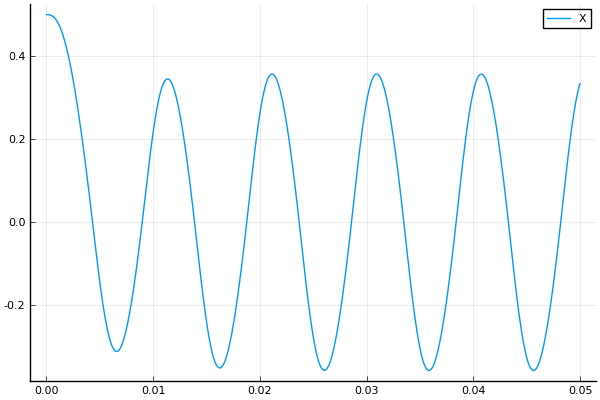

In [16]:
plot(thist,Xhist,label="X")

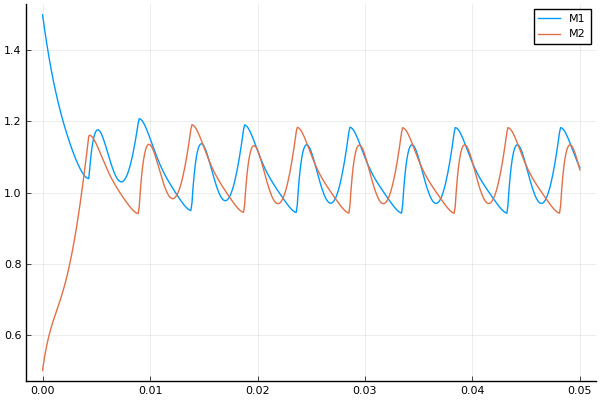

In [17]:
plot(thist,M1hist,label="M1")
plot!(thist,M2hist,label="M2")